# 시계열 분석

## 0. 라이브러리 및 데이터 로딩

In [1]:
# 필요 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller # ADF는 정상성 검정을 위해 사용
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 요소 분해
from statsmodels.tsa.arima.model import ARIMA # ARIMA 모델, SARIMA 모델

import pmdarima as pm # auto arima

#### 정상성 vs 비정상성
`정상성` : 정상성을 띄는 시계열은 해당 시계열이 관측된 시간과 무관(즉, 시간에 따라 상승하거나 주기적인 변화가 있는 추세나 계절성이 없음)

> 특징
- 정상 시계열은 평균이 일정
- 분산이 시점에 의존하지 않음
- 공분산 또한 시점에 의존하지 않음 (시차에는 의존)
------------
- 정상성을 띄는 시계열은 장기적으로 예측 불가능한 시계열 (e.g. 백색잡음 white noise가 대표적인 예)

`비정상성`: 시간에 영향을 받는 시계열 (추세나 계절성이 있는 것이 대표적인 특징)

> 특징
- 시간의 흐름에 따라 시계열의 평균 수준이 다름
- 시간의 흐름에 따라 추세를 가짐 (우상향, 우하향 추세 등)
- 시간의 흐름에 따라 계절성이 있음
- 시간의 흐름에 따라 시계열의 분산이 증가하거나 감소함
-------------
- 비정상성 시계열 예제) 여름에 아이스크림 판매량이 높으며, 겨울에 판매량이 낮다 (계절성)

## 1. 정상 시계열 - 백삭잡음(White noise)

In [2]:
# 정규분포에서 난수 365개 추출
np.random.seed(1)

x = np.random.randn(365)

### 1-1. 원계열 시도표(Time Plot)

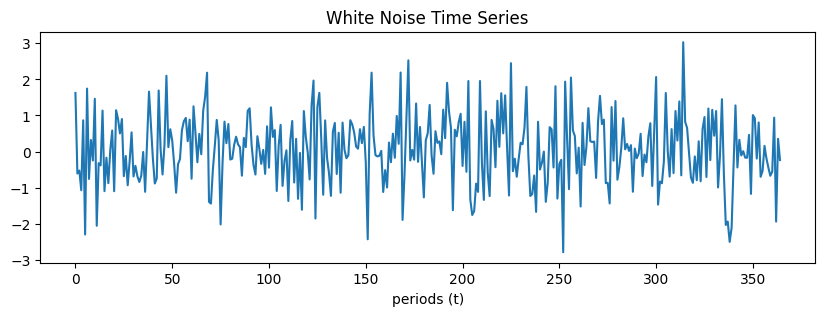

In [3]:
# 백색잡음 시도표
plt.figure(figsize=(10, 3))

plt.plot(np.arange(365), x)
plt.title('White Noise Time Series')
plt.xlabel('periods (t)')
plt.show()

### 1-2. Augmented Dickey Fuller Test 단위근 검정 (ADF test)
#### Augmented Dickey Fuller Test 가설검정
- Ho : 정상성이 있는 시계열이 아님 (단위근)
- H1 : 정상성이 있는 시계열

`귀무가설을 기각해야 정상성이 있는 시계열`
(엄밀히 말하면 ADF 검정 가설 검정은
Ho : 0 = 0 vs H1 : 0 < 0
$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \dots + \delta_p \Delta y_{t-p} + \epsilon_t
$$


\]


In [4]:
# Augmented Dickey Fuller Test (adfuller)
result = adfuller(x)

In [5]:
result

(-19.772523202104036,
 0.0,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 952.9340604979548)

In [7]:
print('ADF stat : {}'.format(result[0]))
print('p-value: {:.4f}'.format(result[1]))
print('Critical Values: ')
for key, value in result[4].items():
    print('\t{} : {:.4f}'.format(key, value))

ADF stat : -19.772523202104036
p-value: 0.0000
Critical Values: 
	1% : -3.4484
	5% : -2.8695
	10% : -2.5710


`결과` : 귀무가설 기각 --> 정상 시계열

### 1-3. ACF와 PACF

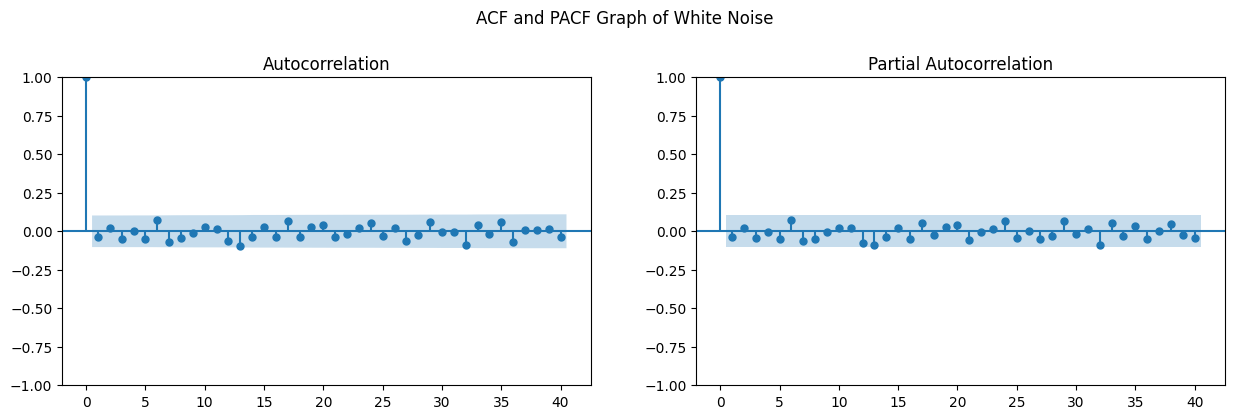

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=axes[1])
fig.suptitle('ACF and PACF Graph of White Noise', y=1.05)
plt.show()

- 자기상관 및 편자기상관 없음 --> 정상성

### 1-4. 비정상성 시계열 (추세 존재)

In [9]:
# 추세 생성 및 백색잡음에 추세 추가
trend = np.linspace(1, 15, 365) # 추세 생성
x_w_trend = x + trend # 백색잡음 x에 추세 추가

### 1-5. 원계열 시도표(Time Plot)

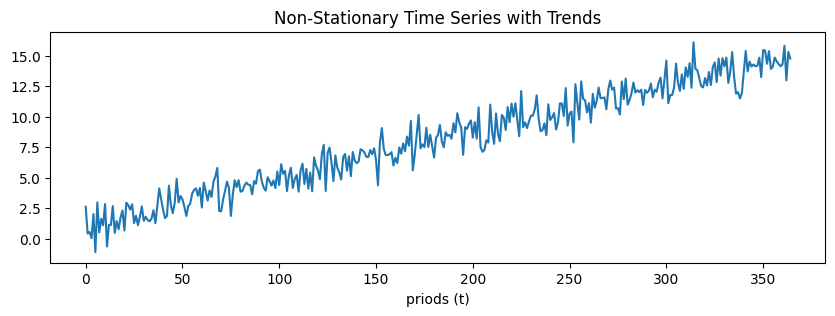

In [10]:
# 추세 존재 시계열의 시도표
plt.figure(figsize=(10, 3))

plt.plot(np.arange(365), x_w_trend)
plt.title('Non-Stationary Time Series with Trends')
plt.xlabel('priods (t)')
plt.show()

### 1-6. Augmented Dickey Fuller Test 단위근 검정(ADF test)
- Augmented Dickey Fuller Test 가설검정
- Ho : 정상성이 있는 시계열이 아님 (단위근)
- H1: 정상성이 있는 시계열
- `귀무가설을 기각해야 정상성이 있는 시계열`

In [11]:
# 비정상 시계열에 대한 단위근 검정 결과
result = adfuller(x_w_trend)
print('ADF stat : {:.4f}'.format(result[0]))
print('p-value: {:.4f}'.format(result[1]))
print('Critical Values: ')
for key, value in result[4].items():
    print('\t{} : {:.4f}'.format(key, value))

ADF stat : -0.7079
p-value: 0.8447
Critical Values: 
	1% : -3.4493
	5% : -2.8699
	10% : -2.5712


- `결론` : 귀무가설 기각 실패 --> 정상성 만족 X

### 1-7. ACF와 PACF

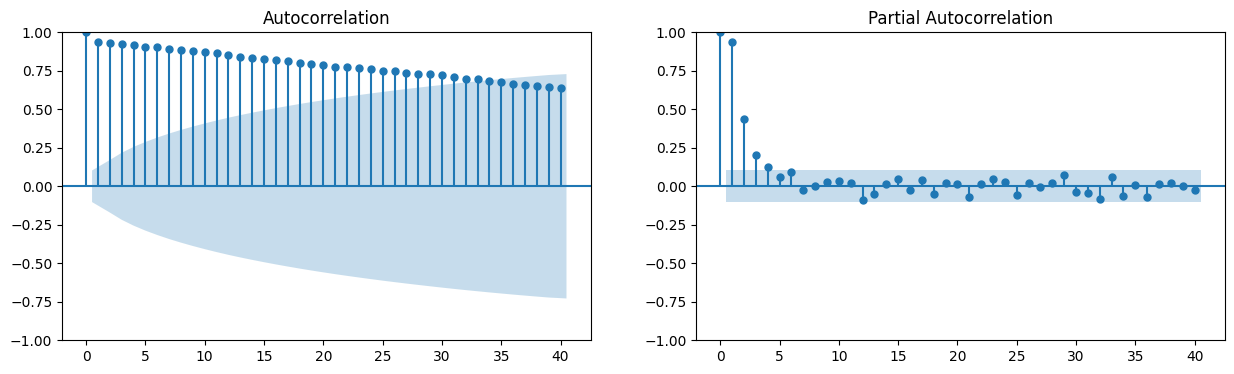

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

fig = sm.graphics.tsa.plot_acf(x_w_trend, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(x_w_trend, lags=40, ax=axes[1])
plt.show()

- 자기상관(Autocorrelation)은 시간이 흐를수록 줄어들고 있음(파란 음영 부분 안으로 들어옴) & 편자기상관(Partial Auto correlation)은 시차 5번째부터 파란 음영부분으로 들어왔음

### 1-8. ARIMA -- AR(5)

In [14]:
# statsmodels가 제공하는 ARIMA 사용
ar_mod = ARIMA(x_w_trend, order=(5, 0, 0)) # AR order만 5, 따라서 AR(5) 모델임

In [15]:
result = ar_mod.fit()

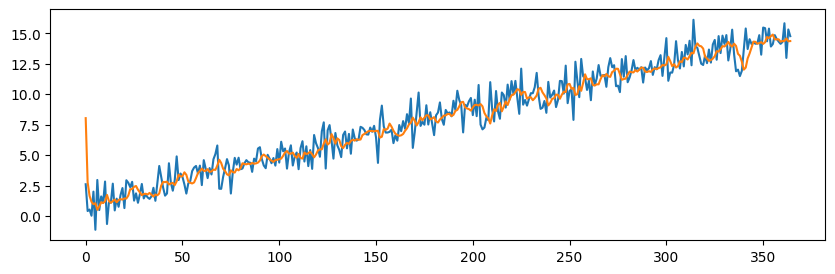

In [16]:
# 실 데이터 vs 모델 결과
plt.figure(figsize=(10, 3))

plt.plot(np.arange(365), x_w_trend)
plt.plot(np.arange(365), result.fittedvalues)
plt.show()

In [17]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -545.109
Date:                Tue, 03 Sep 2024   AIC                           1104.217
Time:                        02:10:46   BIC                           1131.516
Sample:                             0   HQIC                          1115.066
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0428      5.053      1.592      0.111      -1.861      17.947
ar.L1          0.1981      0.048      4.106      0.000       0.104       0.293
ar.L2          0.2489      0.052      4.796      0.0

- Ljung-Box(Q) 통계량의 귀무가설: "잔차(residual)는 백색잡음(white noise)"
- Jarque-Bera(JB) 통계량의 귀무가설: "잔차(residual)는 정규성을 만족"
- 잔차가 정규성을 띈다면, skew는 0, kurtosis는 3에 가까운 것이 특징

In [23]:
print('mean absolute error : {:.4f}'.format(result.mae))

mean absolute error : 0.8551


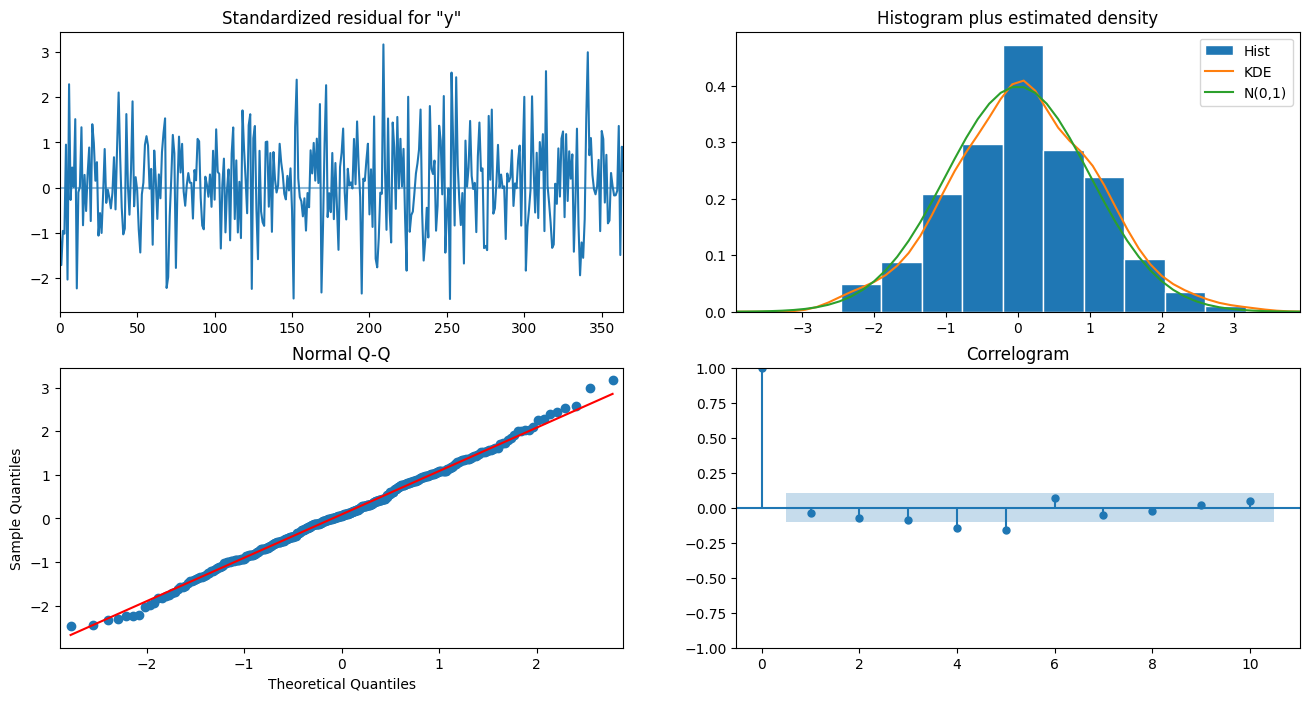

In [21]:
result.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
ar_5 = np.sum(np.abs(x_w_trend - result.fittedvalues))
ar_5

312.1214318159567

### 1-9. ARIMA -- I(1)

In [24]:
# 차분만 이용한 추세 제거 모델링
arima_mod2 = ARIMA(x_w_trend, order=(0, 1, 0))
result = arima_mod2.fit()

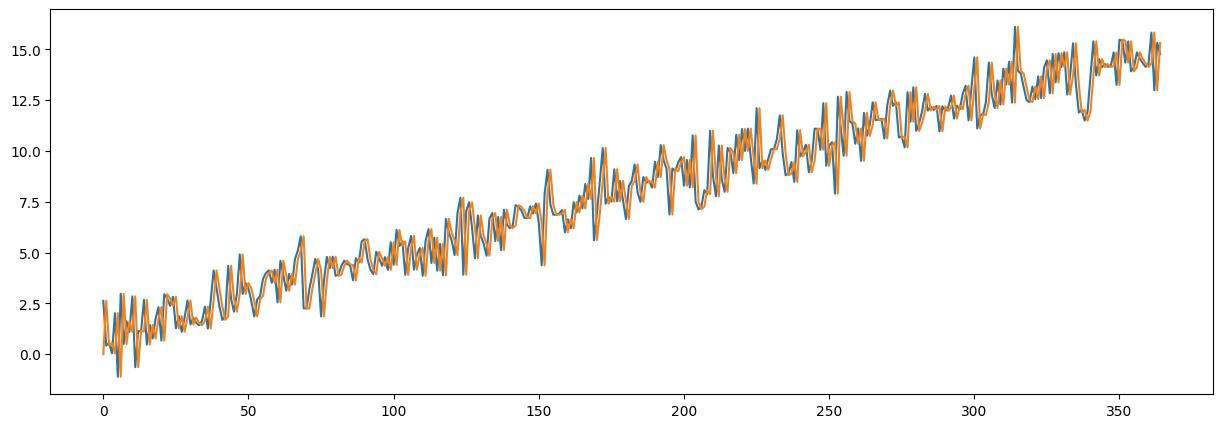

In [25]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(365), x_w_trend)
plt.plot(np.arange(365), result.fittedvalues)
plt.show()

In [26]:
i_1 = np.sum(np.abs(x_w_trend - result.fittedvalues))
i_1

398.3766694444225

In [27]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -634.642
Date:                Tue, 03 Sep 2024   AIC                           1271.284
Time:                        02:19:22   BIC                           1275.181
Sample:                             0   HQIC                          1272.833
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.9139      0.130     14.755      0.000       1.660       2.168
Ljung-Box (L1) (Q):                 100.83   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.00   Pr

In [29]:
print('mean absolute error : {:.4f}'.format(result.mae))

mean absolute error : 1.0914


In [30]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(x_w_trend, result.fittedvalues)
print('mean absolute error : {}'.format(mae))

mean absolute error : 1.091442929984719


In [32]:
pm.arima.auto_arima(x_w_trend,
                    d=1,
                    start_p=0,
                    max_p=5,
                    start_q=0,
                    max_q=5,
                    seasonal=False,
                    step=True,
                    trace=True
                   )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1273.072, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1157.411, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1271.284, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1125.228, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1101.074, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1092.347, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1071.004, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1075.303, Time=0.05 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 1.599 seconds


ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [33]:
arima_mod3 = ARIMA(x_w_trend, order=(5, 1, 0))

In [34]:
result = arima_mod3.fit()

In [35]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -531.651
Date:                Tue, 03 Sep 2024   AIC                           1075.303
Time:                        02:25:23   BIC                           1098.686
Sample:                             0   HQIC                          1084.596
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8423      0.047    -17.886      0.000      -0.935      -0.750
ar.L2         -0.6425      0.069     -9.352      0.000      -0.777      -0.508
ar.L3         -0.5129      0.067     -7.630      0.0

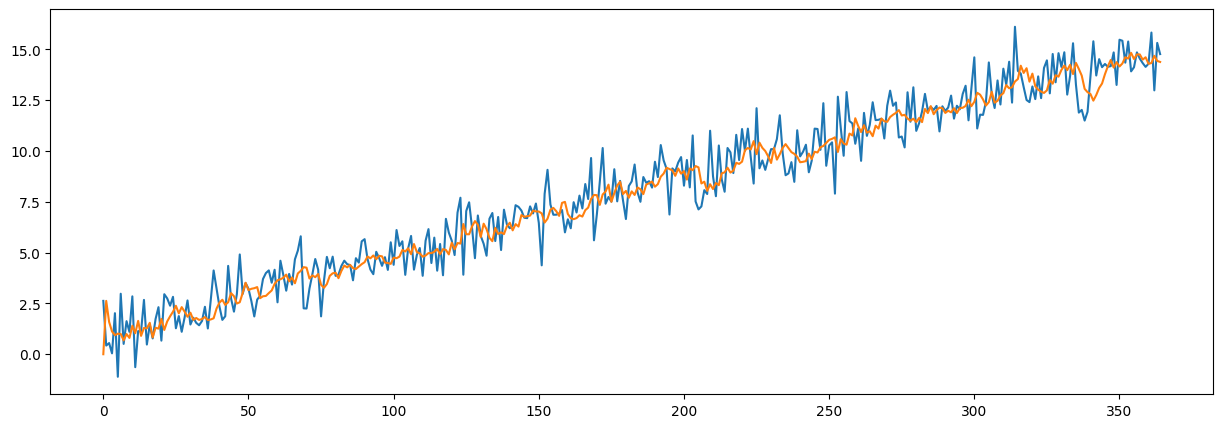

In [36]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(365), x_w_trend)
plt.plot(np.arange(365), result.fittedvalues)
plt.show()

In [37]:
print('mean absolute error : {}'.format(result.mae))

mean absolute error : 0.8300001367652854


### 1-10. 시계열 성분 분해 (Time Series Decomposition)